In [34]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score,recall_score,accuracy_score,roc_curve,auc

<h3> Data Preprocessing and Analysis </h3>

In [2]:
movies_df = pd.read_table("/kaggle/input/movielens-1m-dataset/movies.dat",sep="::",names=['id','title','genres'],encoding='latin-1')
ratings_df = pd.read_table("/kaggle/input/movielens-1m-dataset/ratings.dat",sep="::",names=['user_id','movie_id','rating','timestamp'])

/opt/conda/lib/python3.7/site-packages/pandas/util/_decorators.py:311: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return func(*args, **kwargs)


In [3]:
ratings_df = pd.merge(ratings_df, movies_df, how='left', left_on='movie_id', right_on='id')
ratings_df.head()

,user_id,movie_id,rating,timestamp,id,title,genres
0,1,1193,5,978300760,1193,One Flew Over the Cuckoo's Nest (1975),Drama
1,1,661,3,978302109,661,James and the Giant Peach (1996),Animation|Children's|Musical
2,1,914,3,978301968,914,My Fair Lady (1964),Musical|Romance
3,1,3408,4,978300275,3408,Erin Brockovich (2000),Drama
4,1,2355,5,978824291,2355,"Bug's Life, A (1998)",Animation|Children's|Comedy


In [4]:
ratings_df.describe()

,user_id,movie_id,rating,timestamp,id
count,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06,1.000209e+06
mean,3.024512e+03,1.865540e+03,3.581564e+00,9.722437e+08,1.865540e+03
std,1.728413e+03,1.096041e+03,1.117102e+00,1.215256e+07,1.096041e+03
min,1.000000e+00,1.000000e+00,1.000000e+00,9.567039e+08,1.000000e+00
25%,1.506000e+03,1.030000e+03,3.000000e+00,9.653026e+08,1.030000e+03
50%,3.070000e+03,1.835000e+03,4.000000e+00,9.730180e+08,1.835000e+03
75%,4.476000e+03,2.770000e+03,4.000000e+00,9.752209e+08,2.770000e+03
max,6.040000e+03,3.952000e+03,5.000000e+00,1.046455e+09,3.952000e+03


<AxesSubplot:ylabel='Frequency'>

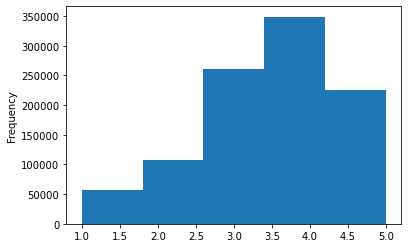

In [5]:
ratings_df.rating.plot.hist(bins=5)

In [6]:
movie_stats = ratings_df.groupby("movie_id",as_index=False).aggregate(
    {'user_id' : 'count', 'rating' : 'mean'}).rename(columns={'user_id' : '#watch', 'rating' : 'avg_rating'})

movie_stats = pd.merge(movie_stats,movies_df,how='left',left_on='movie_id',right_on='id')[['title','#watch','avg_rating']]
movie_stats.head()

,title,#watch,avg_rating
0,Toy Story (1995),2077,4.146846
1,Jumanji (1995),701,3.201141
2,Grumpier Old Men (1995),478,3.016736
3,Waiting to Exhale (1995),170,2.729412
4,Father of the Bride Part II (1995),296,3.006757


[Text(0, 0, '3428'),
 Text(0, 0, '2991'),
 Text(0, 0, '2990'),
 Text(0, 0, '2883'),
 Text(0, 0, '2672'),
 Text(0, 0, '2653'),
 Text(0, 0, '2649'),
 Text(0, 0, '2590'),
 Text(0, 0, '2583'),
 Text(0, 0, '2578')]

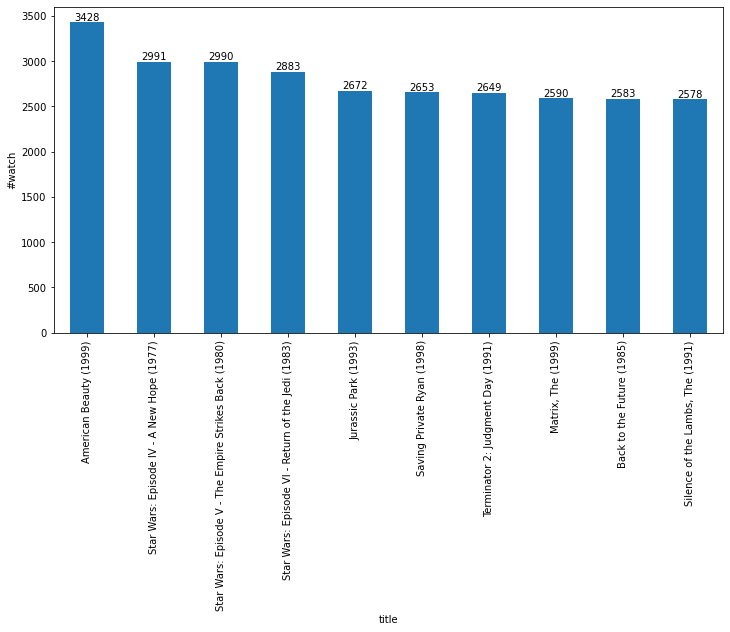

In [7]:
# top 10 most popular movies
ax = movie_stats.sort_values(by=['#watch'],ascending=False)[:10].plot(x='title',y='#watch',kind='bar',figsize=(12,6),legend=False,ylabel='#watch')
ax.bar_label(ax.containers[0])

[Text(0, 0, '4.55456'),
 Text(0, 0, '4.52497'),
 Text(0, 0, '4.51711'),
 Text(0, 0, '4.51042'),
 Text(0, 0, '4.47772'),
 Text(0, 0, '4.47619'),
 Text(0, 0, '4.45369'),
 Text(0, 0, '4.44989'),
 Text(0, 0, '4.41282'),
 Text(0, 0, '4.40626')]

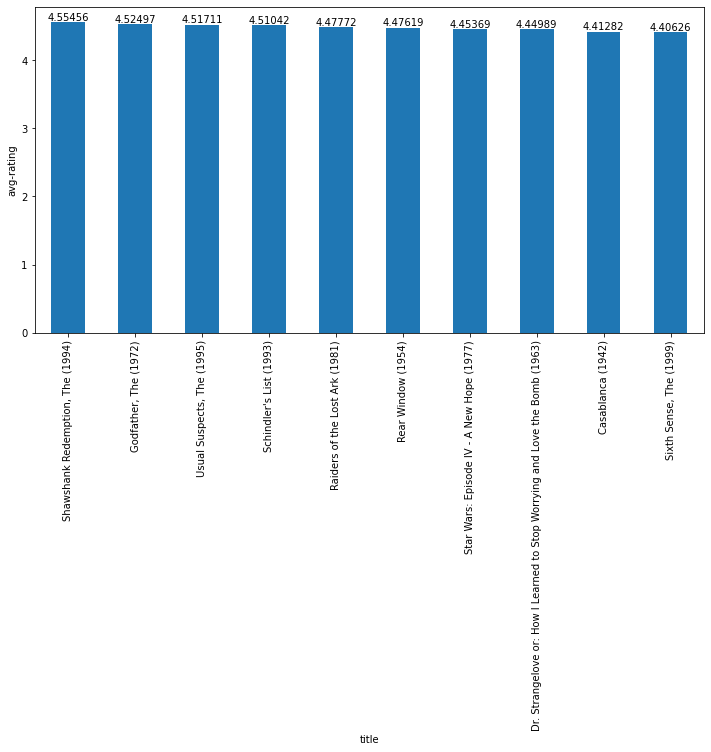

In [8]:
# top 10 most liked movies
ax = movie_stats[movie_stats['#watch'] >= 1000].sort_values(by=['avg_rating'],ascending=False)[:10].plot(x='title',y='avg_rating',kind='bar',figsize=(12,6),legend=False,ylabel='avg-rating')
ax.bar_label(ax.containers[0])

In [9]:
# ratings are converted to binary since we will be working on ctr or like prediction
# 3 and below ratings are considered as dislike, 4 and 5 are considered as like
ratings_df.loc[ratings_df.rating <= 3,'rating'] = 0
ratings_df.loc[ratings_df.rating > 3,'rating'] = 1

In [10]:
ratings_df['rating'].value_counts()

1    575281
0    424928
Name: rating, dtype: int64

In [11]:
# define label encoders for movies and users
user_encoder = preprocessing.LabelEncoder()
movie_encoder = preprocessing.LabelEncoder()

In [12]:
# make sure that all user and movie ids start from 1
ratings_df.user_id = user_encoder.fit_transform(ratings_df.user_id.values)
ratings_df.movie_id = movie_encoder.fit_transform(ratings_df.movie_id.values)

In [13]:
df = ratings_df[['user_id','movie_id','rating']].rename(columns={'rating' : 'like'})
df.head()

,user_id,movie_id,like
0,0,1104,1
1,0,639,0
2,0,853,0
3,0,3177,1
4,0,2162,1


<h3> Model Training and Evaluation </h3>

In [14]:
class MovieLensDataset(Dataset):
    
    def __init__(self, users, movies, ratings):
        self.users = users
        self.movies = movies
        self.ratings = ratings
        
    def __len__(self):
        return len(self.users)
    
    def __getitem__(self,idx):
        user = self.users[idx]
        movie = self.movies[idx]
        rating = self.ratings[idx]
        
        return {
               "users" : torch.tensor(user), 
               "movies" : torch.tensor(movie), 
               "ratings" : torch.tensor(rating)
                }

In [15]:
class CollaborativeFilteringModel(nn.Module):
    def __init__(self,n_users,n_movies,emb_dim=32):
        super().__init__()
        self.user_embeddings = nn.Embedding(n_users,emb_dim)
        self.movie_embeddings = nn.Embedding(n_movies,emb_dim)
        
        self.cosine_sim = nn.CosineSimilarity(dim=1, eps=1e-6)
        
    def forward(self,user,movie):
        user_emb = self.user_embeddings(user)
        movie_emb = self.movie_embeddings(movie)
        
        # apply cosine similarity to user-movie embeddings and scale it between 0-1
        # if user and movie embeddings are similar, that means higher chance to user to like the movie
        output = (self.cosine_sim(user_emb,movie_emb) + 1) / 2

        return output 

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [17]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42, stratify=df.like.values)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42, stratify=test_data.like.values)

In [18]:
train_dataset = MovieLensDataset(train_data.user_id.values, train_data.movie_id.values, train_data.like.values)
val_dataset = MovieLensDataset(val_data.user_id.values, val_data.movie_id.values, val_data.like.values)
test_dataset = MovieLensDataset(test_data.user_id.values, test_data.movie_id.values, test_data.like.values)

In [19]:
train_dl = DataLoader(train_dataset, batch_size=1024,shuffle=True)
val_dl = DataLoader(val_dataset, batch_size=1024,shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=1024,shuffle=True)

In [20]:
user_count = len(ratings_df['user_id'].unique())
movie_count = len(ratings_df['movie_id'].unique())

In [21]:
model = CollaborativeFilteringModel(user_count,movie_count,emb_dim=64)
model.to(device)

CollaborativeFilteringModel(
  (user_embeddings): Embedding(6040, 64)
  (movie_embeddings): Embedding(3706, 64)
  (cosine_sim): CosineSimilarity()
)

In [22]:
optimizer = torch.optim.Adam(model.parameters(),lr=0.1)
loss_function = nn.BCELoss()

In [23]:
epochs = 5
training_losses = []
validation_losses = []
for epoch in range(epochs):

    train_loss = 0.0
    
    model.train()
    # training loop
    for i, data in enumerate(train_dl):
        users = data['users'].to(device)
        movies = data['movies'].to(device)
        
        ratings = data['ratings'].to(device)
        ratings = ratings.view(ratings.shape[0],-1).to(torch.float32)

        optimizer.zero_grad()

        outputs = model(users,movies)
        loss = loss_function(outputs, ratings.squeeze())
        train_loss += loss.item()

        loss.backward()

        optimizer.step()
       
    train_loss /= (i+1)
    training_losses.append(train_loss)
    
    model.eval()
    val_loss = 0.0
    for i, data in enumerate(val_dl):
        users = data['users'].to(device)
        movies = data['movies'].to(device)
        
        ratings = data['ratings'].to(device)
        ratings = ratings.view(ratings.shape[0],-1).to(torch.float32)
        
        outputs = model(users,movies)
        loss = loss_function(outputs, ratings.squeeze())
        val_loss += loss.item()

    val_loss /= (i+1) 
    validation_losses.append(val_loss)
    print(f"Epoch {epoch+1} - Training Loss: {train_loss}, Validation Loss: {val_loss}")

Epoch 1 - Training Loss: 0.6008950721882188, Validation Loss: 0.5400366412133587
Epoch 2 - Training Loss: 0.5150530220526258, Validation Loss: 0.529147284979723
Epoch 3 - Training Loss: 0.5040982698692995, Validation Loss: 0.5262442833306838
Epoch 4 - Training Loss: 0.499428129295254, Validation Loss: 0.5240477764484833
Epoch 5 - Training Loss: 0.4966589735292108, Validation Loss: 0.5233470359627082


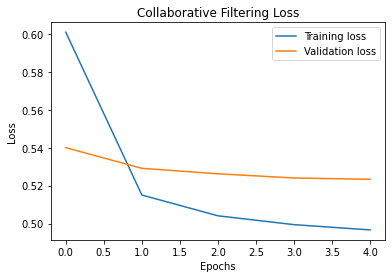

In [29]:
plt.plot(range(epochs),training_losses,label='Training loss')
plt.plot(range(epochs),validation_losses,label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Collaborative Filtering Loss")
plt.legend()
plt.show()

In [24]:
predictions = []
targets = []

# evaluate the model on the test set
with torch.no_grad():
    for i, data in enumerate(test_dl):
        users = data['users'].to(device)
        movies = data['movies'].to(device)

        ratings = data['ratings'].to(device)
        ratings = ratings.view(ratings.shape[0],-1).to(torch.float32)
        targets.extend(ratings.squeeze(dim=1).tolist())

        outputs = model(users,movies)
        predictions.extend(outputs.tolist())

In [26]:
predictions = np.array(predictions)
targets = np.array(targets)

In [31]:
precision = precision_score(targets,np.where(predictions >= 0.5,1,0))
recall = recall_score(targets,np.where(predictions >= 0.5,1,0))
accuracy = accuracy_score(targets,np.where(predictions >= 0.5,1,0))

print(f"Precision: {precision}\nRecall: {recall}\nAccuracy: {accuracy}")

Precision: 0.7470013466537221
Recall: 0.829248366013072
Accuracy: 0.7402545465452255


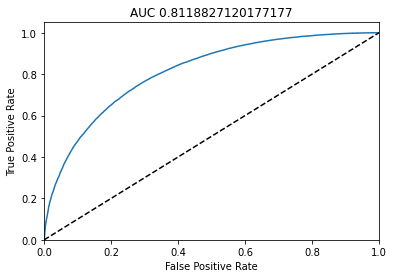

In [28]:
# calculate the auc score
fpr,tpr,_ = roc_curve(targets,predictions)
score = auc(fpr,tpr)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"AUC {score}")
plt.show()

<h3> Recommend Movies </h3>

In [53]:
def recommend_movies(user_id,top_k=10):
    # get all the movie_ids
    unique_movies = ratings_df.movie_id.unique()
    # get the movie_ids that are watched by the user
    watched_movies_by_user = ratings_df[ratings_df['user_id'] == user_id]['movie_id'].values
    # get the movie_ids that are not watched by the user
    not_watched_movies = torch.tensor(list(set(unique_movies) - set(watched_movies_by_user)))
    # create a tensor filled with user_id to fed the model
    user = torch.full((1,not_watched_movies.shape[0]),user_id)
    user = torch.squeeze(user)
    
    with torch.no_grad():
        # make the prediction
        user = user.to(device)
        not_watched_movies = not_watched_movies.to(device)
        movies = model(user,not_watched_movies)
        
    movies = torch.unsqueeze(movies,1)
    movies = torch.cat([torch.unsqueeze(not_watched_movies,1),movies],dim=1)
    # get the top k movies
    movies = movies[movies[:, 1].sort(descending=True)[1]]
    top_k_movies = movies[:top_k,:]
    movie_ids = top_k_movies[:,0].to(int).tolist()
    
    # create a recommendation dataframe
    recommended_movies = pd.DataFrame()
    for idx,m_id in enumerate(movie_ids):
        movie_row = ratings_df[ratings_df['movie_id']==m_id].iloc[0,:]
        title = movie_row.title
        genres = movie_row.genres

        recommended_movies.at[idx,'movie_id'] = m_id
        recommended_movies.at[idx,'score'] = top_k_movies[idx,1].item()
        recommended_movies.at[idx,'title'] = title
        recommended_movies.at[idx,'genres'] = genres
        
    return recommended_movies

In [54]:
top_k_movies = 5
user_id = random.randint(0,user_count+1)

print(f"Recommendations for user: {user_id}")
recommend_movies(user_id,top_k_movies)

Recommendations for user: 1154


,movie_id,score,title,genres
0,828.0,0.898708,Talk of Angels (1998),Drama
1,2850.0,0.890968,Ten Benny (1997),Drama
2,2910.0,0.890200,"End of the Affair, The (1955)",Drama
3,2309.0,0.882843,"Apple, The (Sib) (1998)",Drama
4,2521.0,0.880965,"Killing, The (1956)",Crime|Film-Noir
